# Metrics vs Predictions

In `PhiSpy` there are lots of metrics that you can adapt to suit your needs, but how important is each metric in each prediction?

We have a [snakefile](https://github.com/linsalrob/PhiSpy/blob/master/scripts/phispy_metrics.snakefile) that will make all possible combinations of metrics and run them for you. 

The [parsing code](https://github.com/linsalrob/PhiSpy/blob/master/scripts/summarize_metrics_output.py) generates two files: the first is a list of a code (just an `int`) and the combination of metrics. This is just so the other table is not so big. 

The second output is the table of Accuracy, Precision, Recall, Specificity, and F<sub>1</sub> score for each metric.

In [1]:
import os, sys
import itertools
import re
import json
%matplotlib inline
from random import randint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
from math import log, e
from scipy import stats
from math import sqrt

### Read the metrics

In [2]:
mdf = pd.read_csv('metric_codes.tsv', delimiter="\t", index_col=0, names=['Code', 'Metric'], header=None)
mdf.head(30)

,Metric
Code,
0,none
1,noannotation
2,pg0
3,orf_length_med
4,shannon_slope
5,at_skew
6,gc_skew
7,max_direction
8,phmms


In [3]:
mdf.tail(30)

,Metric
Code,
481,none noannotation orf_length_med shannon_slope...
482,none noannotation orf_length_med shannon_slope...
483,none noannotation orf_length_med shannon_slope...
484,none noannotation orf_length_med at_skew gc_sk...
485,none noannotation shannon_slope at_skew gc_ske...
486,none pg0 orf_length_med shannon_slope at_skew ...
487,none pg0 orf_length_med shannon_slope at_skew ...
488,none pg0 orf_length_med shannon_slope at_skew ...
489,none pg0 orf_length_med shannon_slope gc_skew ...


### Read the results file.

Note that we deliberately set the data types here, because pandas was not guessing them correctly.

In [4]:
dtypes={'Genome': object, 'Metric':np.int64, 'Accuracy':np.float64, 'Precision':np.float64, 'Recall':np.float64, 'Specificity':np.float64, 'F1 score':np.float64}
measures = pd.read_csv("phispy_metrics_tptn.tsv", delimiter="\t", dtype=dtypes, header=None, names=["Genome", "Metric", "Accuracy", "Precision", "Recall", "Specificity", 'F1 score'])
measures.head()

,Genome,Metric,Accuracy,Precision,Recall,Specificity,F1 score
0,Mesorhizobium_loti_MAFF303099,0,0.973,0.000,0.000,0.996,NaN
1,Escherichia_coli_O157-H7_EDL933,0,0.973,0.868,0.920,0.980,0.893
2,Escherichia_coli_CFT073,0,0.993,0.920,0.951,0.995,0.936
3,Escherichia_coli_O157-H7,0,0.978,0.903,0.930,0.985,0.916
4,Ralstonia_solanacearum_GMI1000,0,0.973,0.093,0.308,0.978,0.143


### Find the option with _no_ metrics

We need to find the option with `--metrics none`, `--phage_genes 0`, and `--ignore_annotations`. These are coded as `none`, `pg0`, and `noannotation` respectively.

In [17]:
mdf[mdf['Metric'].str.contains('none') & mdf['Metric'].str.contains('noannotation') & mdf['Metric'].str.contains('pg0')]

,Metric
Code,
45,none noannotation pg0
129,none noannotation pg0 orf_length_med
130,none noannotation pg0 shannon_slope
131,none noannotation pg0 at_skew
132,none noannotation pg0 gc_skew
...,...
503,none noannotation pg0 orf_length_med shannon_s...
504,none noannotation pg0 orf_length_med shannon_s...
505,none noannotation pg0 orf_length_med at_skew g...


#### But no metrics == no phages!

If we turn everything off, (code 45: no metrics, phage genes, or hmms) we do not find any phages! (remove the `.head()` to see more)

In [25]:
measures[(measures['Metric'] == 45)].head()

,Genome,Metric,Accuracy,Precision,Recall,Specificity,F1 score
2160,Mesorhizobium_loti_MAFF303099,45,0.977,NaN,0.0,1.0,NaN
2161,Escherichia_coli_O157-H7_EDL933,45,0.877,NaN,0.0,1.0,NaN
2162,Escherichia_coli_CFT073,45,0.948,NaN,0.0,1.0,NaN
2163,Escherichia_coli_O157-H7,45,0.871,NaN,0.0,1.0,NaN
2164,Ralstonia_solanacearum_GMI1000,45,0.993,NaN,0.0,1.0,NaN


### Find the option with _all_ metrics

Similarly, we need to find the option that includes `orf_length_med`, `shannon_slope`, `at_skew`, `gc_skew`, and `max_direction phmms`, but includes neither `noannotation` nor `pg0`

In [22]:
mdf[~mdf['Metric'].str.contains('none') & ~mdf['Metric'].str.contains('noannotation') & ~mdf['Metric'].str.contains('pg0') & mdf['Metric'].str.contains('orf_length_med') & mdf['Metric'].str.contains('shannon_slope') & mdf['Metric'].str.contains('phmms')] 

,Metric
Code,
112,orf_length_med shannon_slope phmms
242,orf_length_med shannon_slope at_skew phmms
244,orf_length_med shannon_slope gc_skew phmms
245,orf_length_med shannon_slope max_direction phmms
376,orf_length_med shannon_slope at_skew gc_skew p...
377,orf_length_med shannon_slope at_skew max_direc...
378,orf_length_med shannon_slope gc_skew max_direc...
464,orf_length_med shannon_slope at_skew gc_skew m...


### Plot _none_ and _all_ metrics

These sort of represent "none" and "all". These are the two options from above

[Text(0, 0, 'None'), Text(0, 0, 'All')]

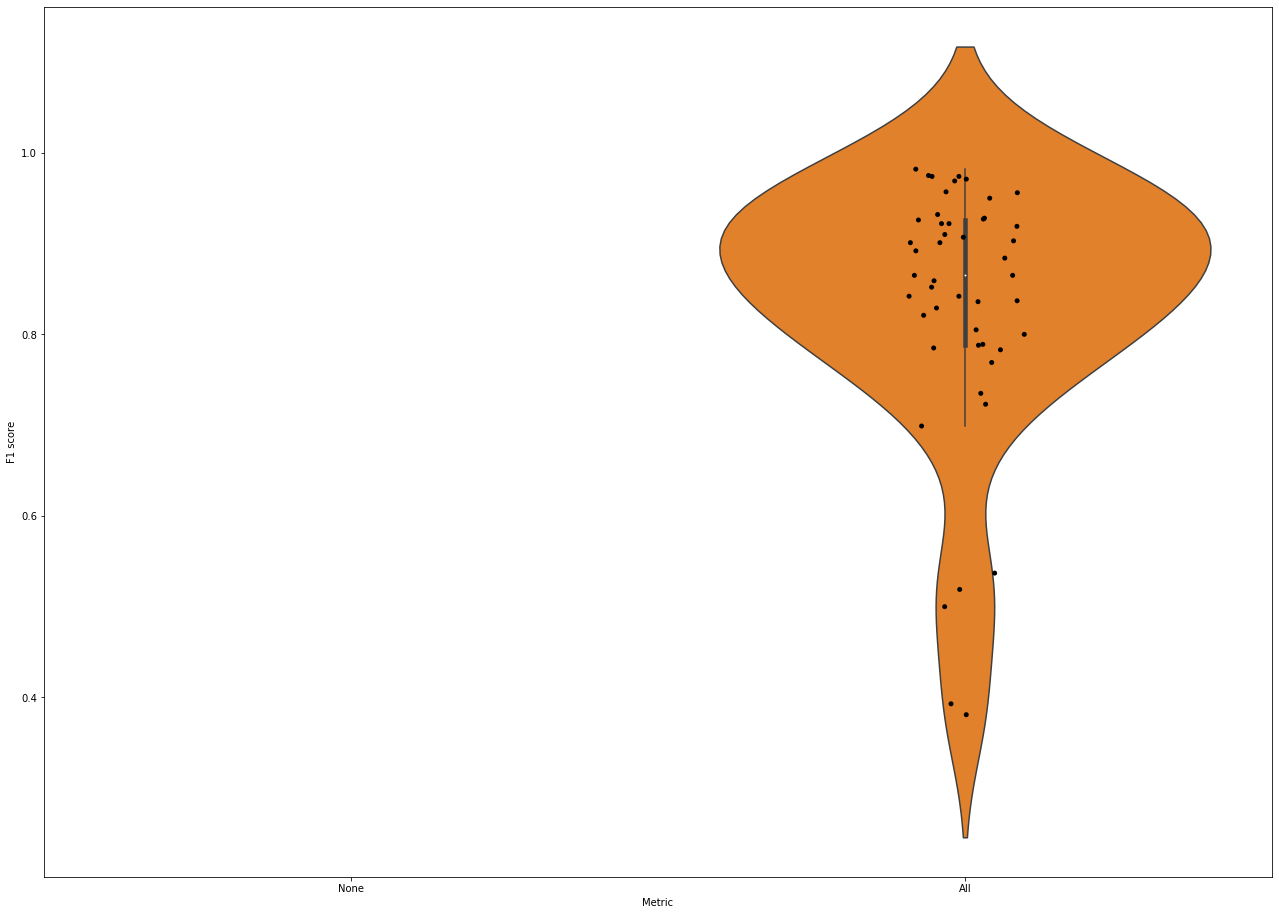

In [23]:
fig, ax = plt.subplots(figsize=(22,16))

m_an = measures[(measures['Metric'] == 45) | (measures['Metric'] == 464)]
sns.violinplot(ax = ax, x="Metric", y="F1 score", data=m_an, scale="count" )
sns.stripplot(ax = ax,  x="Metric", y="F1 score", data=m_an, jitter=True, color="Black")
ax.set_xticklabels(['None', 'All'])

### Plot some selected measures

We have too much data to plot them all, so lets just plot a few selected measures. Chosen almost at random, but not really

[Text(0, 0, 'none'),
 Text(0, 0, 'none pg0 phmms'),
 Text(0, 0, 'pg0 orf_length_med shannon_slope phmms'),
 Text(0, 0, 'at_skew gc_skew max_direction phmms'),
 Text(0, 0, 'orf_length_med shannon_slope at_skew gc_skew max_direction phmms')]

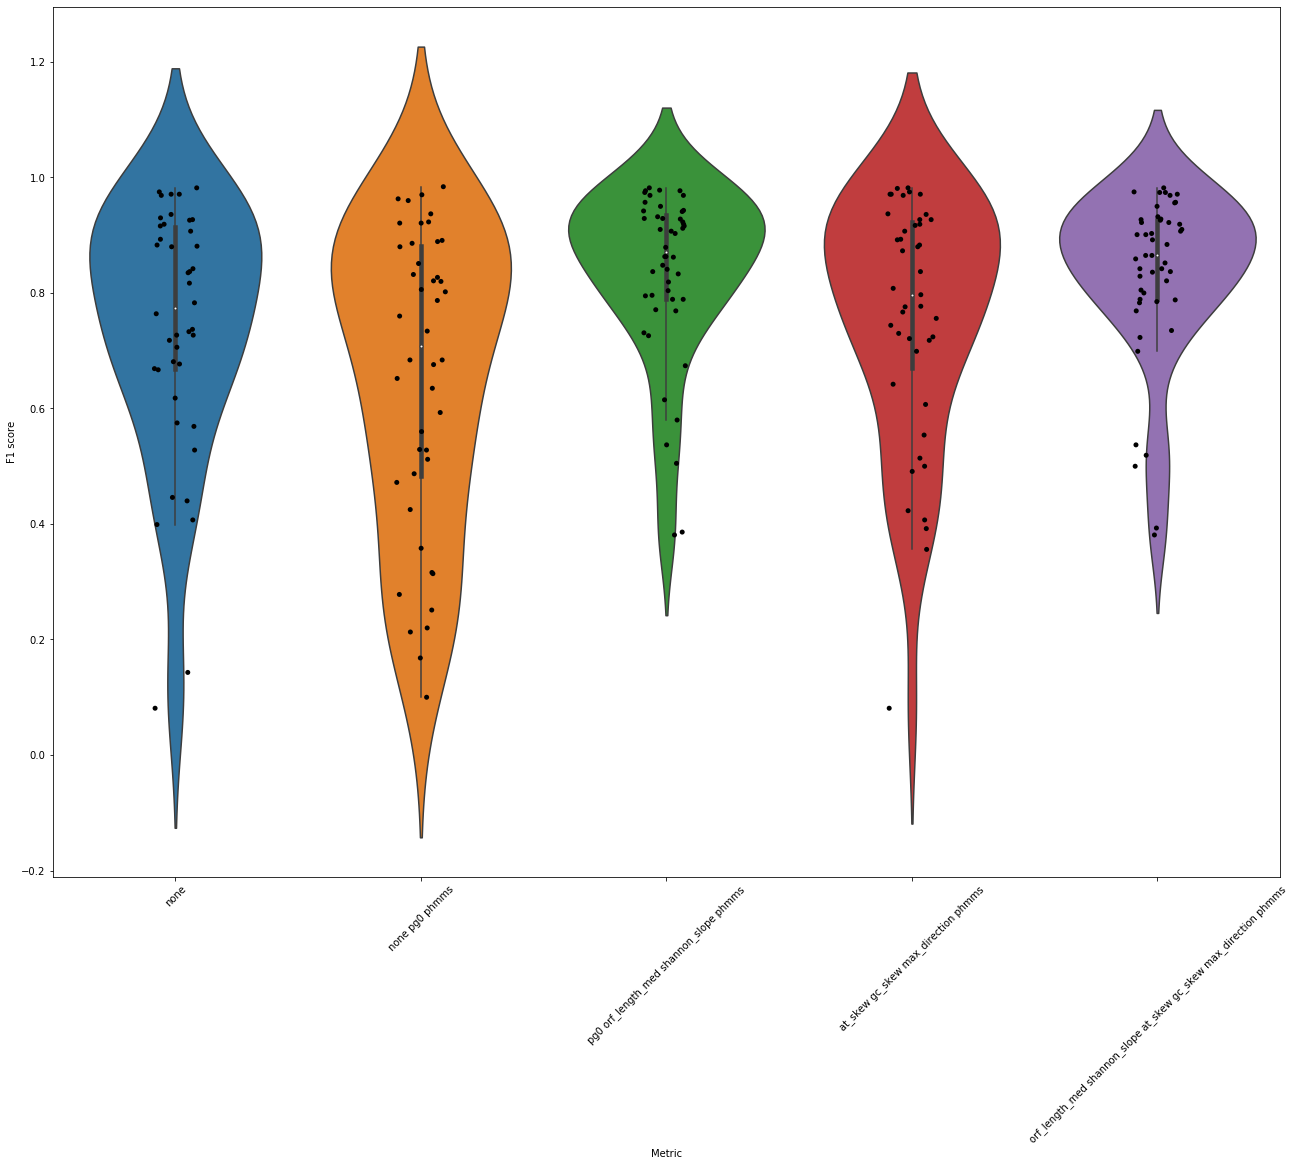

In [27]:
m_some = measures[(measures['Metric'] == 254) | (measures['Metric'] == 0) | (measures['Metric'] == 223)
                  | (measures['Metric'] == 57)
                  | (measures['Metric'] == 464)
                 ]
fig, ax = plt.subplots(figsize=(22,16))


sns.violinplot(ax = ax, x="Metric", y="F1 score", data=m_some, scale="count" )
sns.stripplot(ax = ax,  x="Metric", y="F1 score", data=m_some, jitter=True, color="Black")
ax.set_xticklabels(list(mdf.iloc[m_some['Metric'].unique(),0]), rotation=45)

### Plot each metric alone

Note that for each metric, we need _none_ plus the metric, otherwise the results are misleading. Especially for `--phmms` and `--phagegenes` where the other metrics are set to the default.

So here we plot each metric alone, together with a version of _all_ metrics.

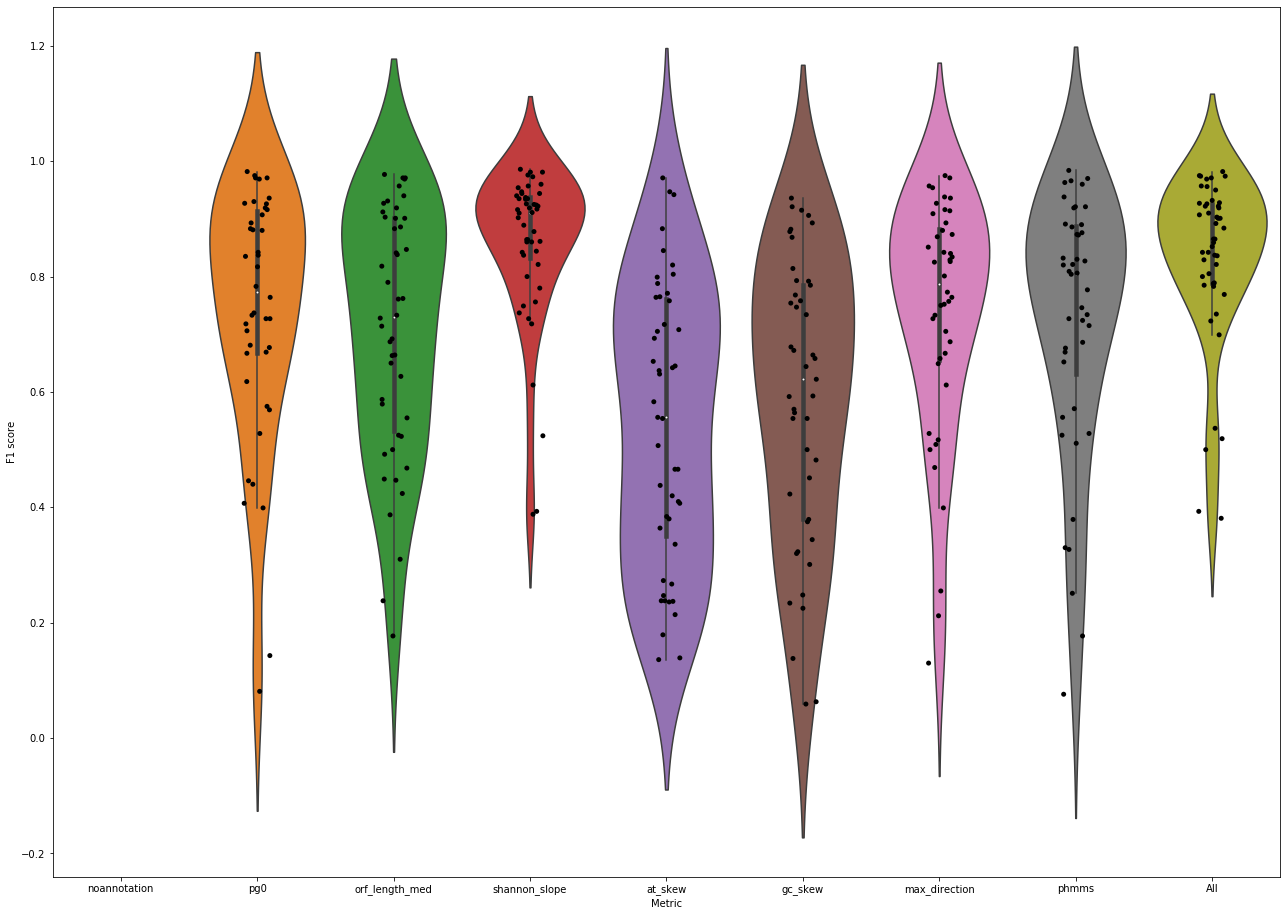

In [30]:
m_alone = measures[((measures['Metric'] >8) & (measures['Metric'] <17))
                   | (measures['Metric'] == 464)
                 ]
fig, ax = plt.subplots(figsize=(22,16))

labels = list(mdf.iloc[m_alone['Metric'].unique(),0])
labels[-1] = "All"
labels = [i.replace('none ', '') for i in labels]

sns.violinplot(ax = ax, x="Metric", y="F1 score", data=m_alone, scale="count" )
sns.stripplot(ax = ax,  x="Metric", y="F1 score", data=m_alone, jitter=True, color="Black")
ax.set_xticklabels(labels)
fig.savefig('metrics_alone.png')

### Summary of the metrics

How do the F<sub>1</sub> scores vary across the metrics?

In [8]:
st = measures[['Metric', 'F1 score']].groupby('Metric').describe()
st.head()

F1 score                                                           
          count      mean       std    min     25%     50%      75%    max
Metric                                                                    
0          42.0  0.737905  0.218573  0.081  0.6675  0.7735  0.91375  0.982
1           0.0       NaN       NaN    NaN     NaN     NaN      NaN    NaN
2          48.0  0.837479  0.135261  0.392  0.7910  0.8675  0.92750  0.982
3          46.0  0.705435  0.215157  0.177  0.5325  0.7305  0.90100  0.977
4          48.0  0.855583  0.137362  0.386  0.8330  0.9105  0.93775  0.986

### Plot the different metrics

Well there are a lot of colours. 

The more metrics we add, the better we get!

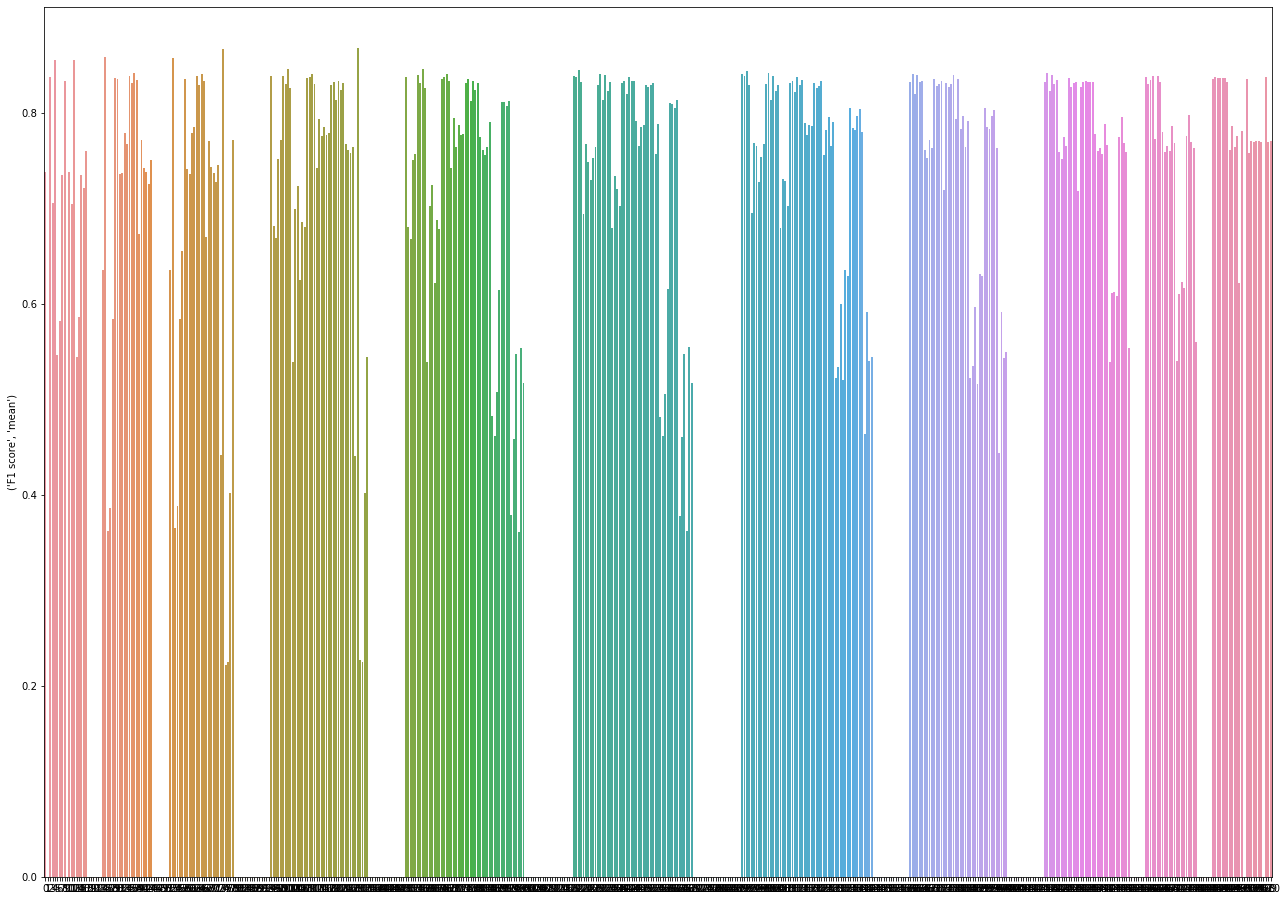

In [9]:
fig, ax = plt.subplots(figsize=(22,16))


sns.barplot(ax = ax, x=st.index.values, y=('F1 score',  'mean'), data=st)

### Find some good, and bad, metrics

Lets see which combinations of metrics are good and bad.

Note that we join the tables here, so we get the definitions of the metrics, not just the numbers.

In [10]:
f_good = st[st[('F1 score',  'mean')] > 0.84]
f_good

F1 score                                                            
          count      mean       std    min      25%     50%      75%    max
Metric                                                                     
4          48.0  0.855583  0.137362  0.386  0.83300  0.9105  0.93775  0.986
12         48.0  0.855417  0.137441  0.388  0.83300  0.9105  0.93775  0.986
25         48.0  0.858771  0.131826  0.388  0.83300  0.9105  0.93875  0.986
37         48.0  0.841667  0.151684  0.296  0.80375  0.8830  0.94125  0.983
53         48.0  0.857313  0.132685  0.388  0.83225  0.9095  0.93875  0.986
65         48.0  0.841083  0.151390  0.296  0.80425  0.8815  0.94100  0.983
74         48.0  0.867167  0.080082  0.612  0.82550  0.8855  0.92600  0.986
101        48.0  0.845562  0.144098  0.296  0.80075  0.8840  0.94125  0.983
111        48.0  0.840938  0.143374  0.381  0.80900  0.8805  0.92750  0.982
130        48.0  0.867354  0.080382  0.612  0.82175  0.8855  0.92600  0.986
157        48.0  0.846188  0.142009  0.296  0.80075  0.8830  0.94125  0.983
167        48.0  0.840521  0.143550  0.381  0.80075  0.8805  0.92825  0.984
222        48.0  0.844375  0.136636  0.381  0.80150  0.8795  0.92825  0.982
231        48.0  0.840979  0.141223  0.298  0.79050  0.8840  0.92875  0.982
290        48.0  0.840833  0.139957  0.386  0.79350  0.8865  0.93700  0.982
292        48.0  0.843646  0.136945  0.381  0.79775  0.8805  0.92825  0.982
301        48.0  0.842083  0.141248  0.298  0.79050  0.8800  0.93000  0.982
361        48.0  0.840458  0.134961  0.393  0.78950  0.8800  0.92800  0.982
363        48.0  0.840083  0.136385  0.389  0.77950  0.8775  0.92625  0.987
378        48.0  0.840083  0.144868  0.381  0.80475  0.8925  0.93050  0.987
417        48.0  0.841313  0.134414  0.395  0.79650  0.8825  0.92725  0.982

In [11]:
pd.merge(f_good, mdf, left_index=True, right_index=True)

/usr/lib/python3/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(F1 score, count)","(F1 score, mean)","(F1 score, std)","(F1 score, min)","(F1 score, 25%)","(F1 score, 50%)","(F1 score, 75%)","(F1 score, max)",Metric
4,48.0,0.855583,0.137362,0.386,0.83300,0.9105,0.93775,0.986,shannon_slope
12,48.0,0.855417,0.137441,0.388,0.83300,0.9105,0.93775,0.986,none shannon_slope
25,48.0,0.858771,0.131826,0.388,0.83300,0.9105,0.93875,0.986,pg0 shannon_slope
37,48.0,0.841667,0.151684,0.296,0.80375,0.8830,0.94125,0.983,shannon_slope max_direction
53,48.0,0.857313,0.132685,0.388,0.83225,0.9095,0.93875,0.986,none pg0 shannon_slope
65,48.0,0.841083,0.151390,0.296,0.80425,0.8815,0.94100,0.983,none shannon_slope max_direction
74,48.0,0.867167,0.080082,0.612,0.82550,0.8855,0.92600,0.986,noannotation pg0 shannon_slope
101,48.0,0.845562,0.144098,0.296,0.80075,0.8840,0.94125,0.983,pg0 shannon_slope max_direction
111,48.0,0.840938,0.143374,0.381,0.80900,0.8805,0.92750,0.982,orf_length_med shannon_slope max_direction
130,48.0,0.867354,0.080382,0.612,0.82175,0.8855,0.92600,0.986,none noannotation pg0 shannon_slope


In [12]:
f_bad = st[st[('F1 score',  'mean')] < 0.5]
f_bad_code = pd.merge(f_bad, mdf, left_index=True, right_index=True)
f_bad_code

,"(F1 score, count)","(F1 score, mean)","(F1 score, std)","(F1 score, min)","(F1 score, 25%)","(F1 score, 50%)","(F1 score, 75%)","(F1 score, max)",Metric
26,47.0,0.361617,0.259578,0.032,0.14550,0.3010,0.50350,0.971,pg0 at_skew
27,45.0,0.386244,0.279664,0.027,0.16600,0.3410,0.56700,0.960,pg0 gc_skew
54,47.0,0.364851,0.259334,0.032,0.15850,0.3100,0.50600,0.971,none pg0 at_skew
55,45.0,0.388022,0.279312,0.026,0.16500,0.3520,0.58500,0.920,none pg0 gc_skew
73,45.0,0.441778,0.222852,0.040,0.23400,0.4840,0.57900,0.890,noannotation pg0 orf_length_med
75,44.0,0.221773,0.171986,0.006,0.08150,0.1695,0.32900,0.569,noannotation pg0 at_skew
76,40.0,0.225150,0.195290,0.002,0.08600,0.1565,0.33750,0.719,noannotation pg0 gc_skew
77,36.0,0.402083,0.173376,0.089,0.28875,0.4140,0.54100,0.708,noannotation pg0 max_direction
129,45.0,0.440378,0.223867,0.040,0.22600,0.4840,0.57900,0.890,none noannotation pg0 orf_length_med
131,43.0,0.227326,0.176758,0.007,0.08200,0.1610,0.33950,0.617,none noannotation pg0 at_skew


In [13]:
max(st[('F1 score',  'mean')])

0.8673541666666669